## scikit-learn digits dataset example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [5]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [6]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### create model

In [7]:
'''
chose landmarks from sample
pick 20 landmarks data each digit
'''
np.random.seed(0)
num_lm0 = 20
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X_sc[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
init_wgt.shape

(200, 64)

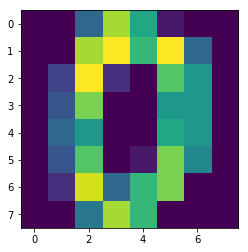

In [8]:
plt.imshow(X[0].reshape((8,8)))

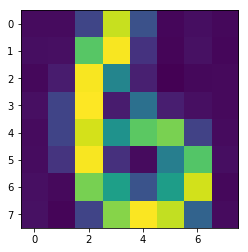

In [9]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [10]:
np.random.seed(0)
num_lm2 = 100
num_lm3 = 50


def make_modelz():
    inp = Input(shape=(64,), name='inp')
    oup = inp
    
    oup_gk1 = GaussianKernel(num_lm, 64, kernel_gamma=1./(2.*64*0.1), weights=[init_wgt], name='gkernel1')(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup_gk2 = GaussianKernel(num_lm2, num_lm, kernel_gamma=1./(2.*num_lm*0.1), name='gkernel2')(oup_gk1)
    model_gk2 = Model(inp, oup_gk2)
    
    oup_gk3 = GaussianKernel(num_lm3, num_lm2, kernel_gamma=1./(2.*num_lm2*0.1), name='gkernel3')(oup_gk2)
    model_gk3 = Model(inp, oup_gk3)
    
    oup = Dense(10, activation='softmax')(oup_gk3)
    
    model = Model(inp, oup)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return {
        'model': model,
        'model_gk1': model_gk1,
        'model_gk2': model_gk2,
        'model_gk3': model_gk3,
    }

models = make_modelz()
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 64)                0         
_________________________________________________________________
gkernel1 (GaussianKernel)    (None, 200)               12800     
_________________________________________________________________
gkernel2 (GaussianKernel)    (None, 100)               20000     
_________________________________________________________________
gkernel3 (GaussianKernel)    (None, 50)                5000      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 38,310
Trainable params: 38,310
Non-trainable params: 0
_________________________________________________________________


### train

In [11]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [12]:
y_pred = model.predict(X_sc)
y_pred

array([[  9.05771792e-01,   4.54785659e-05,   3.28440219e-04, ...,
          1.92711392e-04,   1.98152661e-02,   6.86772093e-02],
       [  2.89941207e-04,   4.56769079e-01,   4.40257862e-02, ...,
          3.58143121e-01,   5.50942905e-02,   4.01605805e-03],
       [  3.06400470e-03,   3.21547359e-01,   5.19344434e-02, ...,
          3.27984184e-01,   1.39705598e-01,   1.92224067e-02],
       ..., 
       [  1.14468904e-02,   1.97997168e-01,   9.19804163e-03, ...,
          2.31724277e-01,   8.99995044e-02,   1.24419052e-02],
       [  4.24584597e-01,   2.17746035e-03,   1.12010231e-02, ...,
          5.90231642e-03,   1.74318552e-01,   3.22234899e-01],
       [  1.53470770e-01,   2.43510418e-02,   3.91385667e-02, ...,
          4.71377485e-02,   3.34110737e-01,   2.51007378e-01]], dtype=float32)

In [13]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[171,   0,   0,   0,   0,   0,   3,   0,   1,   3],
       [  0, 139,   5,   0,   1,   2,   2,  23,  10,   0],
       [  0,   4, 134,  11,   0,  11,   0,   6,   8,   3],
       [  0,   0,  15, 154,   0,   1,   0,   0,   1,  12],
       [  0,   3,   0,   0, 173,   0,   4,   1,   0,   0],
       [  0,   2,  65,   3,   1,  30,   2,   6,  26,  47],
       [  1,   1,   0,   0,   5,   0, 173,   1,   0,   0],
       [  0, 116,   3,   0,   5,   4,   1,  49,   1,   0],
       [  2,   7,   9,   0,   0,  19,   4,  12,  83,  38],
       [  2,   0,   2,   5,   0,   5,   2,   8,  21, 135]])

In [14]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.97      0.96      0.97       178
          1       0.51      0.76      0.61       182
          2       0.58      0.76      0.65       177
          3       0.89      0.84      0.87       183
          4       0.94      0.96      0.95       181
          5       0.42      0.16      0.24       182
          6       0.91      0.96      0.93       181
          7       0.46      0.27      0.34       179
          8       0.55      0.48      0.51       174
          9       0.57      0.75      0.65       180

avg / total       0.68      0.69      0.67      1797



### plot output of GaussianKernel layer #1

In [15]:
lm2 = model.get_layer('gkernel2').get_weights()[0]
lm2.shape

(100, 200)

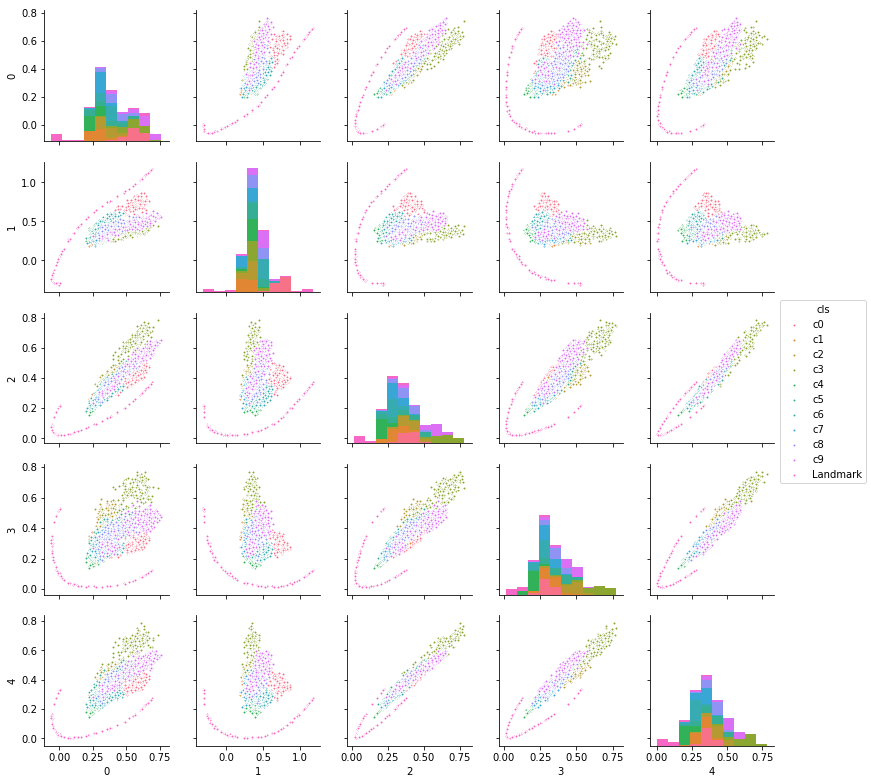

In [16]:
gk1_pred = models['model_gk1'].predict(X_sc)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

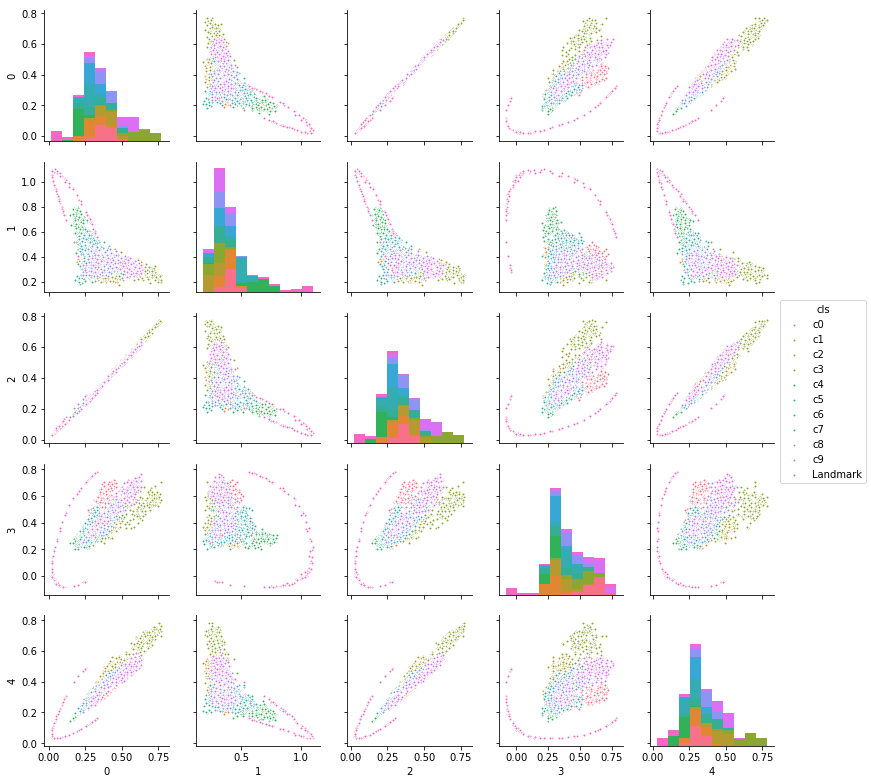

In [17]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #2

In [18]:
lm3 = model.get_layer('gkernel3').get_weights()[0]
lm3.shape

(50, 100)

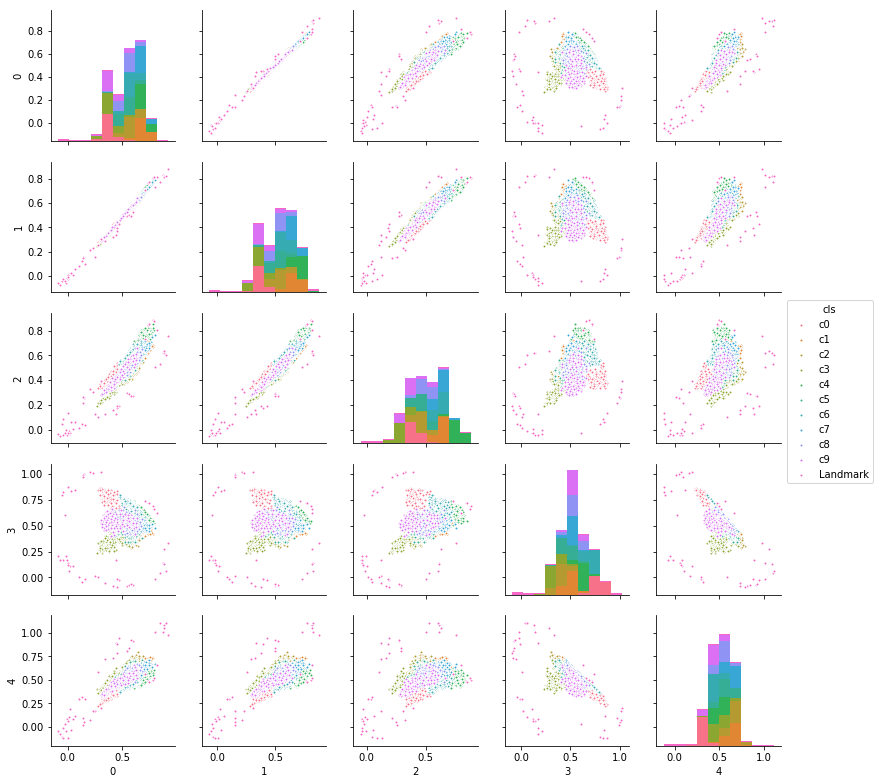

In [19]:
gk2_pred = models['model_gk2'].predict(X_sc)
df = pd.DataFrame(np.vstack([gk2_pred, lm3])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm3.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

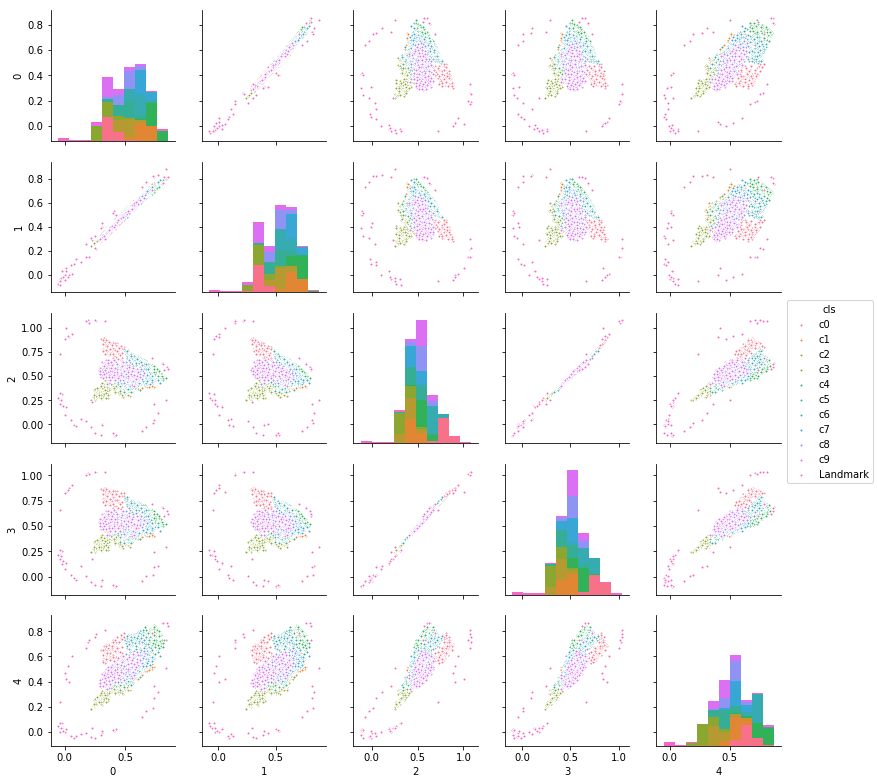

In [20]:
df = pd.DataFrame(np.vstack([gk2_pred, lm3])[:,20:25])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm3.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #3

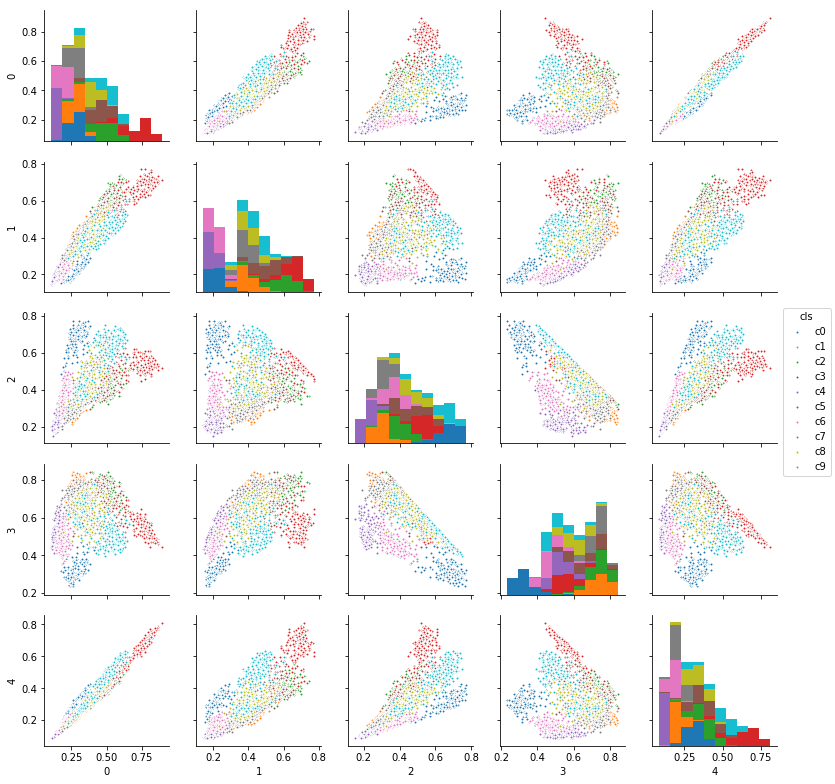

In [21]:
gk3_pred = models['model_gk3'].predict(X_sc)
df = pd.DataFrame(gk3_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

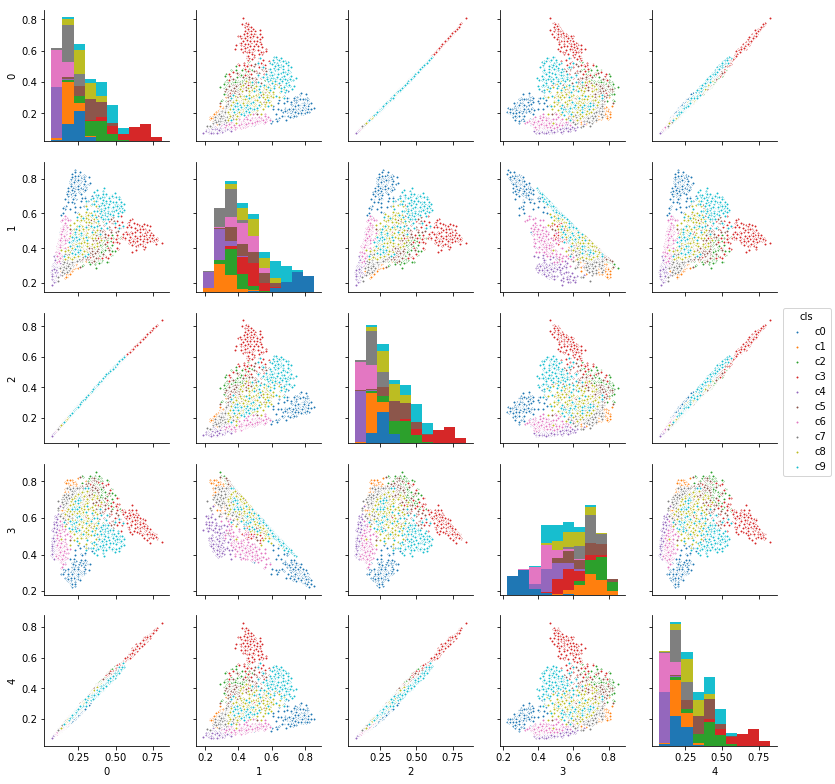

In [22]:
df = pd.DataFrame(gk3_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### train more

In [23]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=1500)

### predict

In [24]:
y_pred = model.predict(X_sc)
y_pred

array([[  9.96228456e-01,   1.21978035e-12,   1.40053899e-14, ...,
          5.19471402e-12,   2.77582367e-05,   3.71182477e-03],
       [  4.02058227e-08,   9.86661017e-01,   3.08614853e-03, ...,
          3.21557978e-03,   5.29358443e-03,   2.63420384e-06],
       [  2.15677115e-10,   7.06634484e-03,   9.73093271e-01, ...,
          3.05518000e-07,   1.94467250e-02,   9.94126026e-07],
       ..., 
       [  1.11020498e-04,   1.05767980e-01,   1.24103995e-03, ...,
          3.79046628e-06,   5.38782001e-01,   8.49476128e-05],
       [  8.50939229e-02,   2.24937321e-06,   1.97575014e-06, ...,
          3.65187657e-06,   1.18410960e-01,   7.87478507e-01],
       [  6.86029613e-04,   4.47049411e-03,   1.48776278e-03, ...,
          3.86136435e-06,   9.73468542e-01,   3.48229497e-03]], dtype=float32)

In [25]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[173,   0,   0,   0,   0,   1,   2,   0,   1,   1],
       [  0, 180,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2, 179,   0,   0,   0,   1,   1,   0],
       [  0,   3,   0,   0, 176,   0,   0,   0,   2,   0],
       [  0,   0,   0,   1,   0, 175,   0,   1,   1,   4],
       [  0,   2,   0,   0,   1,   0, 177,   0,   1,   0],
       [  0,   1,   0,   0,   0,   1,   0, 177,   0,   0],
       [  0,   5,   3,   1,   0,   0,   0,   0, 162,   3],
       [  0,   0,   0,   6,   0,   7,   0,   0,   2, 165]])

In [26]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99       178
          1       0.94      0.99      0.97       182
          2       0.96      1.00      0.98       177
          3       0.96      0.98      0.97       183
          4       0.99      0.97      0.98       181
          5       0.95      0.96      0.96       182
          6       0.99      0.98      0.98       181
          7       0.99      0.99      0.99       179
          8       0.95      0.93      0.94       174
          9       0.95      0.92      0.93       180

avg / total       0.97      0.97      0.97      1797



### plot output of GaussianKernel layer #1

In [27]:
lm2 = model.get_layer('gkernel2').get_weights()[0]
lm2.shape

(100, 200)

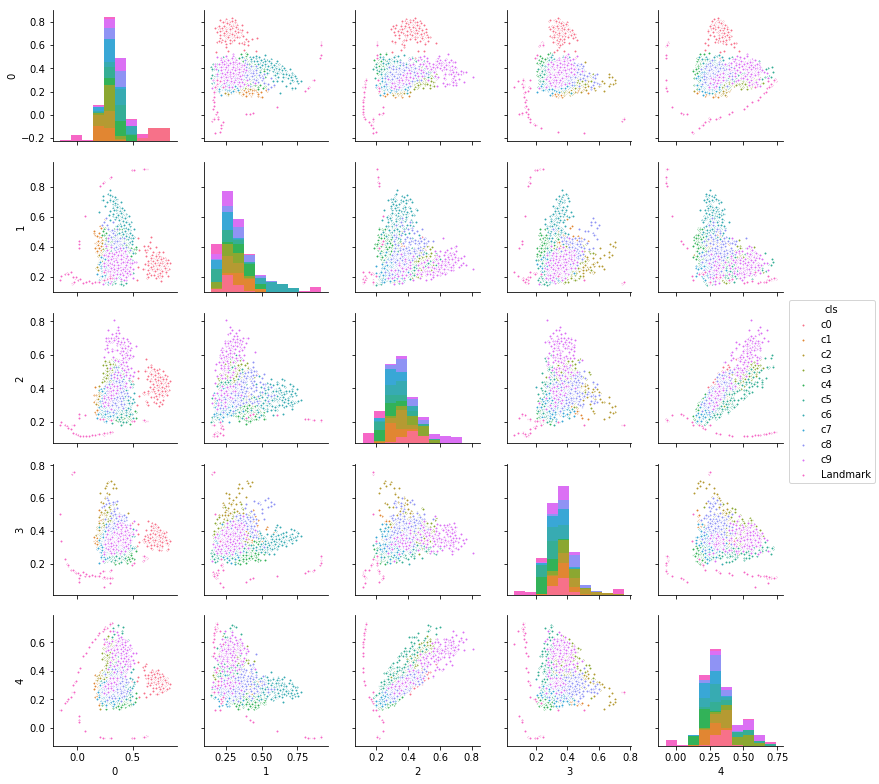

In [28]:
gk1_pred = models['model_gk1'].predict(X_sc)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

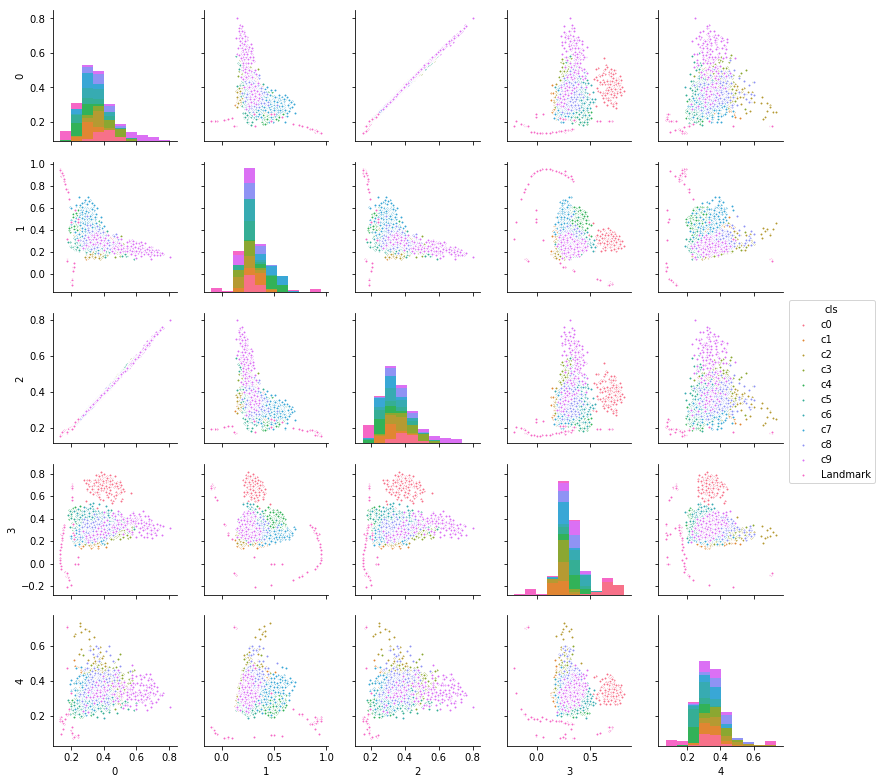

In [29]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #2

In [30]:
lm3 = model.get_layer('gkernel3').get_weights()[0]
lm3.shape

(50, 100)

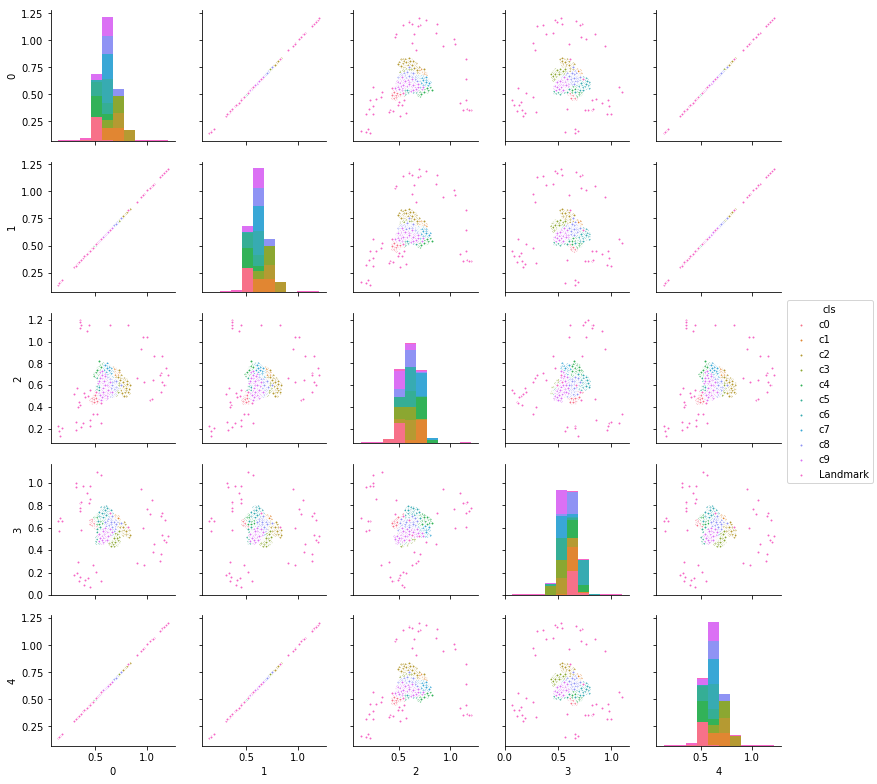

In [31]:
gk2_pred = models['model_gk2'].predict(X_sc)
df = pd.DataFrame(np.vstack([gk2_pred, lm3])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm3.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

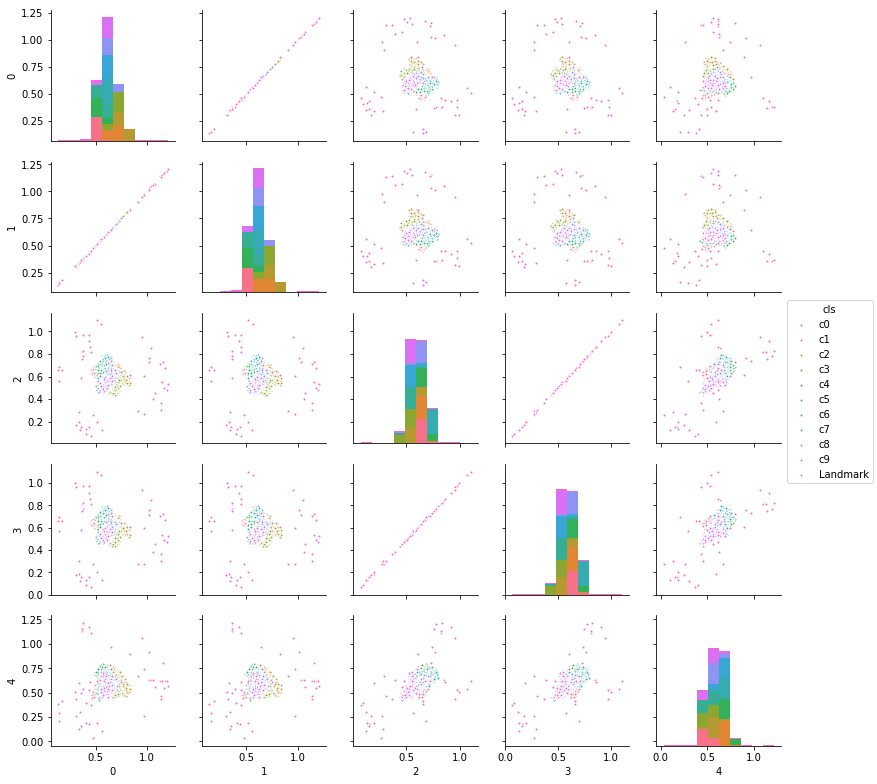

In [32]:
df = pd.DataFrame(np.vstack([gk2_pred, lm3])[:,20:25])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm3.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #3

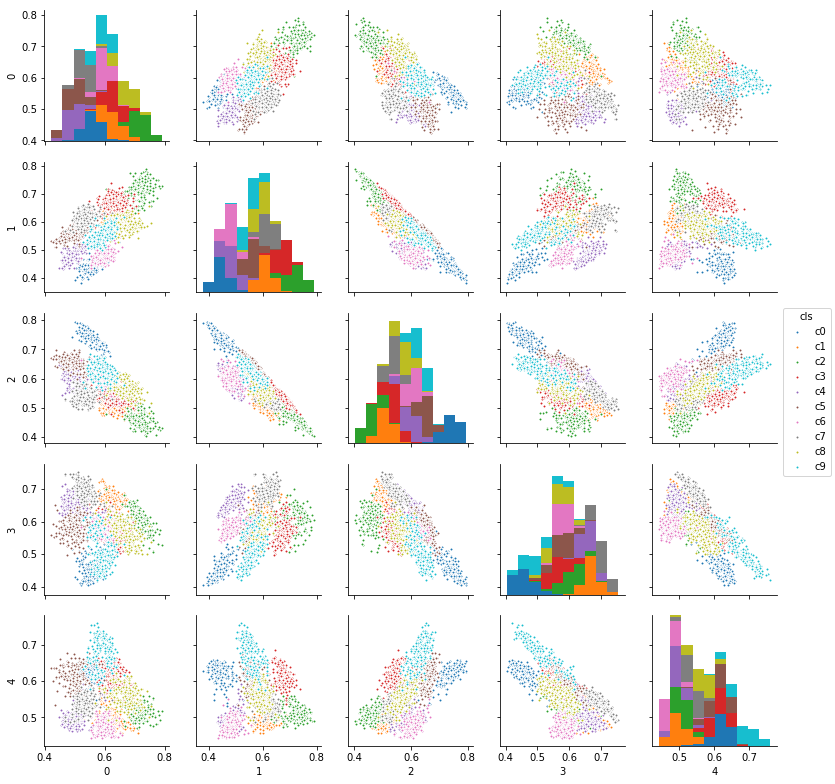

In [33]:
gk3_pred = models['model_gk3'].predict(X_sc)
df = pd.DataFrame(gk3_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

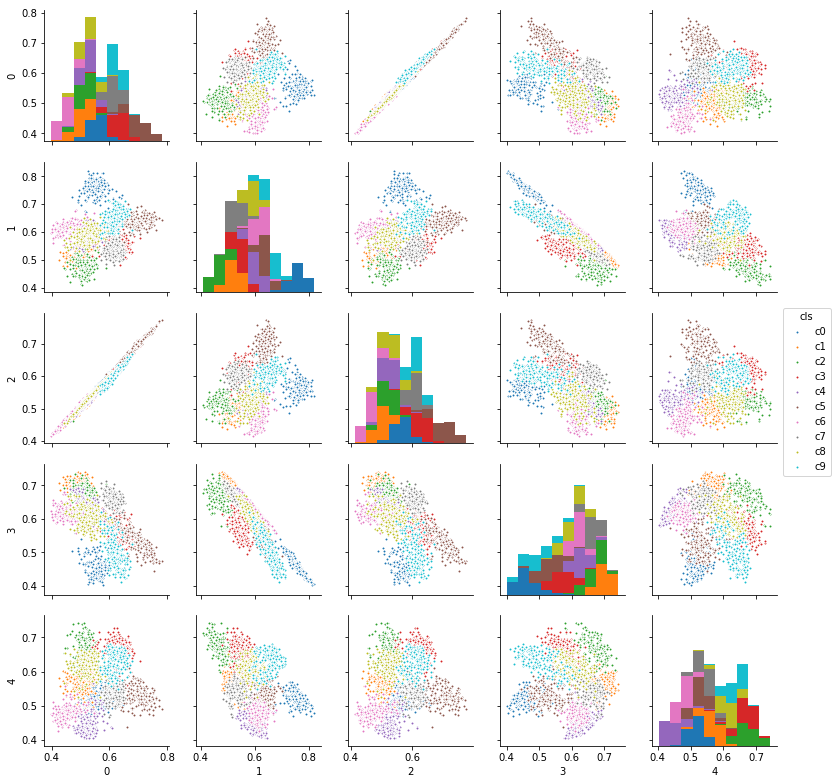

In [34]:
df = pd.DataFrame(gk3_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)